# Boston Marathon Clustering Challenge

The Boston Marathon is one of the most prestegious and history-filled foot race in the world.  The BAA organization publishes data for each race and participant -- this data has been [scraped and compiled into a GitHub repo](https://github.com/llimllib/bostonmarathon).  For this exercise we will use several clustering algortihms in an attempt to group similar runners together.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans,  MeanShift, \
    estimate_bandwidth, SpectralClustering, AffinityPropagation
from sklearn.metrics import silhouette_score, adjusted_rand_score

sns.set_style('whitegrid')
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
url = 'https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv'
df = pd.read_csv(filepath_or_buffer=url, header=0)

In [3]:
df.shape

(31984, 21)

In [4]:
df.sample(5)

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
21608,59.33,"Mcpeak, Marty",301,152.03,M,66,276.72,24645,13980,NaN,223.67,24379,10.57,OH,187.60,28.93,126.58,119.95,USA,Shaker Heights,262.33
13293,47.22,"Elsinger, Jennifer M",179,118.83,F,41,205.30,15206,1458,NaN,169.57,7878,7.83,VT,143.90,23.37,100.02,94.92,USA,Richmond,194.70
9584,44.95,"Anderson, Priscilla R.",596,112.83,F,37,197.53,10970,741,NaN,161.78,5811,7.55,OR,136.67,22.47,94.93,89.98,USA,Murphy,186.80
16128,48.40,"Dunn, Robyn",3148,124.28,F,35,227.90,18438,5014,NaN,184.15,14725,8.70,CA,151.83,24.18,103.68,98.23,USA,Hermosa Beach,214.30
28037,49.58,"Kosinski, Jillian A.",1699,123.50,F,28,211.20,31553,2263,NaN,175.07,9685,8.07,NY,149.73,25.55,104.13,98.75,USA,West Seneca,200.32


In [5]:
cols = df.columns.tolist()

In [6]:
# Re-ordering the columns
cols = ['name', 
        'gender', 
        'age',  
        '5k', 
        '10k', 
        '20k', 
        'half', 
        '25k', 
        '30k', 
        '35k', 
        '40k', 
        'official', 
        'pace', 
        'overall', 
        'division',
        'genderdiv', 
        'city', 
        'state', 
        'country', 
        'ctz', 
        'bib',
]

df = df[cols]

In [7]:
df.head()

,name,gender,age,5k,10k,20k,half,25k,30k,35k,40k,official,pace,overall,division,genderdiv,city,state,country,ctz,bib
0,"Yamamoto, Hiroyuki",M,47,8.02,17.37,37.65,39.72,47.67,59.18,71.40,80.43,85.25,3.27,8,8,8,Fukuoka,NaN,JPN,NaN,W1
1,"Jeptoo, Rita",F,33,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95,5.30,21,1,1,Eldoret,NaN,KEN,NaN,F1
2,"Van Dyk, Ernst F.",M,41,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60,3.08,1,1,1,Paarl,NaN,RSA,NaN,W2
3,"Dibaba, Mare",F,24,16.20,32.57,65.83,69.47,82.43,99.33,116.37,132.95,140.58,5.37,27,3,3,Shoa,NaN,ETH,NaN,F2
4,"Hokinoue, Kota",M,40,8.02,17.12,36.58,38.60,46.37,57.03,67.83,76.72,81.23,3.10,2,2,2,Nogata Fukuoka,NaN,JPN,NaN,W3


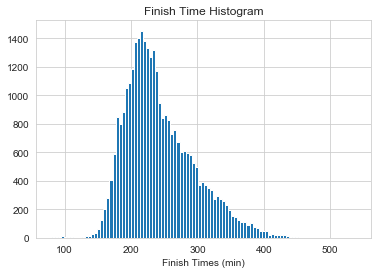

In [8]:
plt.hist(df['official'], bins=100)
plt.title('Finish Time Histogram')
plt.xlabel('Finish Times (min)')
plt.show()

In [9]:
(df['official'] < 120).sum()

43

There are wheelchair racers mixed in this dataset.  Wheelchairs are significantly faster than runners. We will remove them based on their bib numbers.

In [10]:
df.drop(df[df['bib'].str.contains('W')].index, inplace=True)

In [11]:
df.shape

(31931, 21)

In [12]:
df.describe()

,age,official,pace,overall,division,genderdiv
count,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000
mean,42.419968,243.223522,9.284285,15966.000000,1935.744073,8064.377752
std,11.314113,52.037284,1.982437,9217.830059,1714.871975,4746.662139
min,18.000000,128.620000,4.920000,1.000000,1.000000,1.000000
25%,34.000000,205.680000,7.850000,7983.500000,614.000000,3992.000000
50%,42.000000,232.430000,8.870000,15966.000000,1428.000000,7983.000000
75%,50.000000,273.325000,10.430000,23948.500000,2614.000000,11974.500000
max,81.000000,538.880000,20.570000,31931.000000,6979.000000,17575.000000


In [13]:
# Checking data types because the times look to not be numeric
df.dtypes

name          object
gender        object
age            int64
5k            object
10k           object
20k           object
half          object
25k           object
30k           object
35k           object
40k           object
official     float64
pace         float64
overall        int64
division       int64
genderdiv      int64
city          object
state         object
country       object
ctz           object
bib           object
dtype: object

In [14]:
# Checking for missing data
print('Missing Data as percentage of total')
for col in cols:
    missing = (df[col].isna()).sum()
    if missing != 0:
        percent = round((missing / df.shape[0]) * 100, 2)
        print(col, ':', percent)

Missing Data as percentage of total
city : 0.0
state : 8.01
ctz : 96.11


In [15]:
# Some split times are missing but demarcated with "-", counting all those for each split column
for col in df.columns[3:11]:
    string = (df[col].str.contains('-')).sum()
    print(col, ':', string)

5k : 52
10k : 50
20k : 51
half : 72
25k : 216
30k : 40
35k : 34
40k : 39


Small enough numbers that we can drop these with no ill effect.

In [16]:
# Replacing the '-' with NaN
for col in df.columns[3:11]:
    df[col] = np.where(df[col].str.contains('-'), np.NaN, df[col])

# Converting split times to numeric
for col in df.columns[3:11]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
df.dropna(subset=df.columns[3:11].tolist(), inplace=True)

In [17]:
df.sample(10)

,name,gender,age,5k,10k,20k,half,25k,30k,35k,40k,official,pace,overall,division,genderdiv,city,state,country,ctz,bib
18790,"Greenland, Anita C",F,49,26.50,52.77,105.85,111.63,132.53,160.58,189.22,218.28,231.03,8.82,15579,742,5494,Greensboro,NC,USA,NaN,21460
6421,"Nordstrand, Barry",M,51,24.48,48.85,97.87,103.40,122.53,148.18,177.15,206.60,220.97,8.43,12716,1197,8876,Excelsior,MN,USA,NaN,7302
21867,"Desjardins, Linda",F,66,28.90,58.82,120.18,126.75,153.85,189.93,229.53,266.22,281.90,10.77,25077,48,10779,Hampton,NH,USA,NaN,24938
13467,"Daniels, Claire R.",F,28,22.72,46.22,97.03,102.65,124.25,153.20,185.48,216.62,230.23,8.78,15361,3297,5364,Whistler,BC,CAN,NaN,15401
24450,"Levitsky, Keith A.",M,36,24.95,49.48,98.88,104.37,124.48,153.65,194.43,250.30,268.73,10.25,23261,4622,13472,Brentwood,NH,USA,NaN,27705
24724,"Arena, Anastasia E.",F,20,22.52,45.23,93.87,99.28,119.65,148.75,181.07,216.93,233.42,8.92,16218,3484,5857,Brighton,MA,USA,NaN,28001
15437,"Quick, Virginia M.",F,31,24.62,49.62,99.52,104.90,124.42,150.67,177.27,204.80,217.30,8.30,11555,2273,3217,Rockville,MD,USA,NaN,17649
4441,"Cusick, Jonathan",M,23,20.63,41.15,81.72,86.15,102.40,124.23,148.67,181.22,192.65,7.35,4720,2559,4253,Cambridge,MA,USA,NaN,5058
20929,"Devereaux, Elaine",F,51,26.58,54.75,114.85,121.03,144.28,175.73,208.27,240.17,253.80,9.68,20747,786,8443,Fayetteville,NY,USA,NaN,23881
8289,"Yaker, Michael",M,47,21.73,44.97,92.97,98.20,118.78,147.17,178.08,208.43,220.58,8.42,12588,1639,8811,New York,NY,USA,NaN,9457


In [18]:
df.dtypes

name          object
gender        object
age            int64
5k           float64
10k          float64
20k          float64
half         float64
25k          float64
30k          float64
35k          float64
40k          float64
official     float64
pace         float64
overall        int64
division       int64
genderdiv      int64
city          object
state         object
country       object
ctz           object
bib           object
dtype: object

In [19]:
# Converting gender to OHE with Male = 0, Female = 1
df['gender'] = np.where(df['gender'] == 'M', 0, 1)

# Male-Female Clustering

We'll keep it simple initially and only cluster to predict gender based on age and final time.

In [20]:
Y_gender = df['gender']
X_gender = df.iloc[:, [2,11]]
X_gendernorm = normalize(X_gender, axis=0)

X_g_train, X_g_test, Y_g_train, Y_g_test = train_test_split(X_gendernorm,
                                                            Y_gender,
                                                            stratify=Y_gender, 
                                                            test_size=.5)


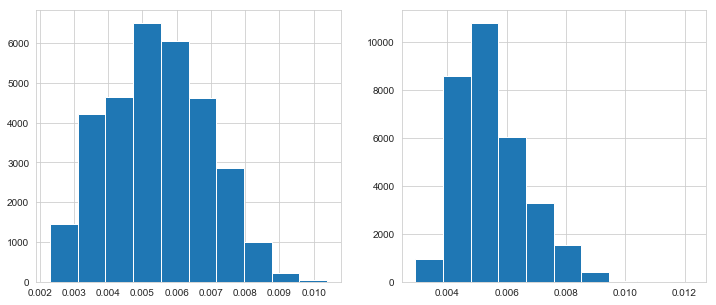

In [21]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(X_gendernorm[:,0])

plt.subplot(122)
plt.hist(X_gendernorm[:,1])
plt.show()

Adjusted Rand Score:  0.016447436636833502


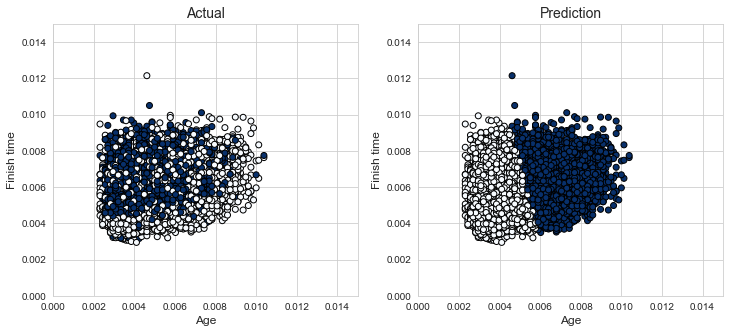

In [22]:
# Instantiating the KMeans model
kmeans_gender = KMeans(n_clusters=2).fit(X_g_train)
Y_g_km_pred = kmeans_gender.predict(X_g_test)

# Evaluation
print('Adjusted Rand Score: ', adjusted_rand_score(Y_g_test, Y_g_km_pred))


# Plotting the true and predicted clusters
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(X_g_test[:, 0], X_g_test[:, 1], c=Y_g_test, cmap='Blues', edgecolors='k')
plt.title('Actual', size=14)
plt.xlabel('Age', size=12)
plt.ylabel('Finish time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)

plt.subplot(122)
plt.scatter(X_g_test[:, 0], X_g_test[:, 1], c=Y_g_km_pred, cmap='Blues', edgecolors='k')
plt.title('Prediction', size=14)
plt.xlabel('Age', size=12)
plt.ylabel('Finish time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)
plt.show()

That's...not a good model.  Let's see if the other clustering algorithms can do better, starting with mean shift.

Mean Shift Bandwidth:  0.001640487805138852
Adjusted Rand Score:  0.00014385754957390787


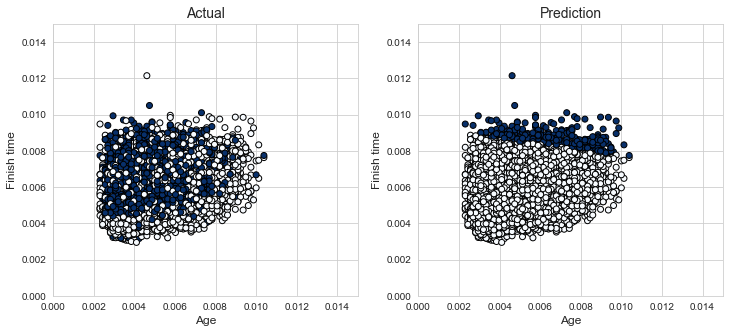

In [23]:
# Estimating the bandwidth hyperparameter
bw = estimate_bandwidth(X_g_train, quantile=0.3, n_jobs=3)

# Instantiating the mean shift model
meanshift_gender = MeanShift(bandwidth=bw, n_jobs=3).fit(X_g_train)
Y_g_ms_pred = meanshift_gender.predict(X_g_test)

# Evaluation
print('Mean Shift Bandwidth: ', bw)
print('Adjusted Rand Score: ', adjusted_rand_score(Y_g_test, Y_g_ms_pred))


# Plotting the true and predicted clusters
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(X_g_test[:, 0], X_g_test[:, 1], c=Y_g_test, cmap='Blues', edgecolors='k')
plt.title('Actual', size=14)
plt.xlabel('Age', size=12)
plt.ylabel('Finish time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)

plt.subplot(122)
plt.scatter(X_g_test[:, 0], X_g_test[:, 1], c=Y_g_ms_pred, cmap='Blues', edgecolors='k')
plt.title('Prediction', size=14)
plt.xlabel('Age', size=12)
plt.ylabel('Finish time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)
plt.show()

Well, that didn't go well.  Predicting all one class is not ideal.  While the bandwidth estimate is very low, it seems to have been too high to get an outcome with more than one cluster.  Let's try manually setting it lower.

Mean Shift Bandwidth:  0.001640487805138852
Number of clusters:  4
Adjusted Rand Score:  0.046030277930352054


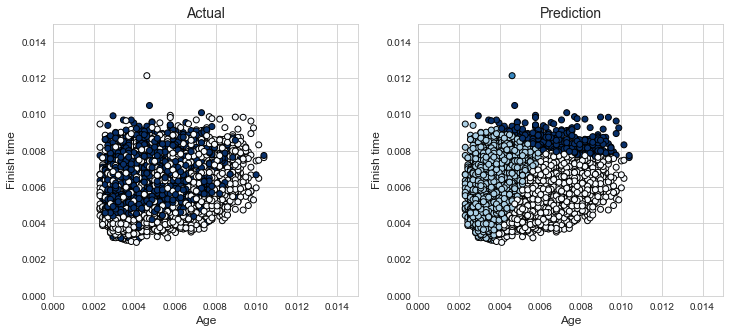

In [24]:
# Instantiating the mean shift model with bandwidth set to 45% of the previous estimate
meanshift_gender = MeanShift(bandwidth=(bw*.45), n_jobs=3).fit(X_g_train)
Y_g_ms_pred = meanshift_gender.predict(X_g_test)

# Evaluation
print('Mean Shift Bandwidth: ', bw)
print('Number of clusters: ', len(np.unique(meanshift_gender.labels_)))
print('Adjusted Rand Score: ', adjusted_rand_score(Y_g_test, Y_g_ms_pred))


# Plotting the true and predicted clusters
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(X_g_test[:, 0], X_g_test[:, 1], c=Y_g_test, cmap='Blues', edgecolors='k')
plt.title('Actual', size=14)
plt.xlabel('Age', size=12)
plt.ylabel('Finish time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)

plt.subplot(122)
plt.scatter(X_g_test[:, 0], X_g_test[:, 1], c=Y_g_ms_pred, cmap='Blues', edgecolors='k')
plt.title('Prediction', size=14)
plt.xlabel('Age', size=12)
plt.ylabel('Finish time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)
plt.show()

We got a result with two clusters, however, the ARI is worse than KMeans.  Let's try spectral clustering next.

Adjusted Rand Score:  0.01361813640823607


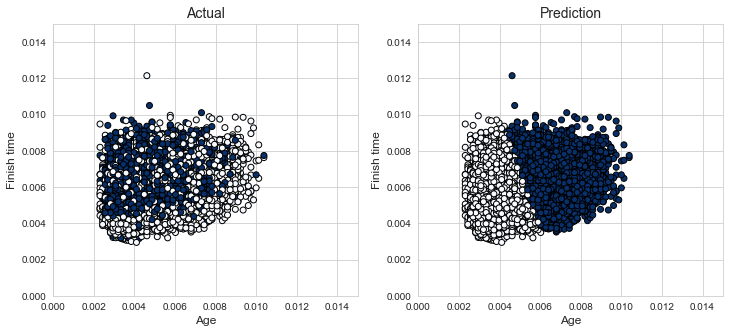

In [25]:
# Spectral Clustering model instantiation
sc_gender = SpectralClustering(n_clusters=2, n_jobs=3)
Y_g_sc_pred = sc_gender.fit_predict(X_g_test)

# Evaluation
print('Adjusted Rand Score: ', adjusted_rand_score(Y_g_test, Y_g_sc_pred))


# Plotting the true and predicted clusters
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(X_g_test[:, 0], X_g_test[:, 1], c=Y_g_test, cmap='Blues', edgecolors='k')
plt.title('Actual', size=14)
plt.xlabel('Age', size=12)
plt.ylabel('Finish time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)

plt.subplot(122)
plt.scatter(X_g_test[:, 0], X_g_test[:, 1], c=Y_g_sc_pred, cmap='Blues', edgecolors='k')
plt.title('Prediction', size=14)
plt.xlabel('Age', size=12)
plt.ylabel('Finish time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)
plt.show()

This is a similar solution to KMeans, but has a slightly worse ARI.  Let's try to grid search the hyperparameters a bit.

In [27]:
# Grid search using different kernel coefficients for 
# the Spectral Clustering algorithm.

# Kernel coefficient for the RBF kernal
# gamma = [1, .75, .5, .25, .05]

# for g in gamma:
#     sc_gender = SpectralClustering(n_clusters=2, n_jobs=3, gamma=g)
#     Y_g_sc_pred = sc_gender.fit_predict(X_g_test)
#     ARI = adjusted_rand_score(Y_g_test, Y_g_sc_pred)
#     print(g, '\t', ARI)

The default Spectral Clustering method seems to perform the best.

## Initial Results

Obviously clustering around gender is leading to poor results because they are not well segmented groups.  Perhaps we can drill down further and create better groups.  Let's try binning the runners into their divisions - that is, gender and binned age - to create what should be better natural clusters.

# Gender and Age Divisions

In [28]:
def division(df):
    '''Returns a encoded division number based on runner sex and age'''
    
    if df[1] == 0:    # Men
        if df[2] < 40:
            return 0
        elif df[2] < 44:
            return 1
        elif df[2] < 49:
            return 2
        elif df[2] < 54:
            return 3
        elif df[2] < 59:
            return 4
        elif df[2] < 64:
            return 5
        elif df[2] < 69:
            return 6
        elif df[2] < 74:
            return 7
        elif df[2] < 79:
            return 8
        else:
            return 9
    if df[1] == 1:    # Women
        if df[2] < 40:
            return 10
        elif df[2] < 44:
            return 11
        elif df[2] < 49:
            return 12
        elif df[2] < 54:
            return 13
        elif df[2] < 59:
            return 14
        elif df[2] < 64:
            return 15
        elif df[2] < 69:
            return 16
        else:
            return 17    # There are very few old women running, need to combine some age bins here



In [29]:
df['DivGroup'] = df.apply(division, axis=1)

In [30]:
df['DivGroup'].value_counts()

10    6891
0     5877
2     2929
3     2538
12    2239
1     2108
11    1932
4     1921
13    1673
5     1185
14     867
6      637
15     379
7      187
16     140
8       50
17      33
9       10
Name: DivGroup, dtype: int64

Now we have the sex/age divisions created.

In [49]:
# Creating the features, predict the DivGroup, using official time and 
# half marathon time as inputs. We have to drop age and gender as inputs 
# because the were used to create the DivGroup target.
Y_division = df['DivGroup']
X_division = df.loc[:, ['official', 'half']]
X_divisionnorm = normalize(X_division, axis=0)

X_d_train, X_d_test, Y_d_train, Y_d_test = train_test_split(X_divisionnorm,
                                                            Y_division,
                                                            stratify=Y_division, 
                                                            test_size=.5)

Adjusted Rand Score:  0.04441542730712808


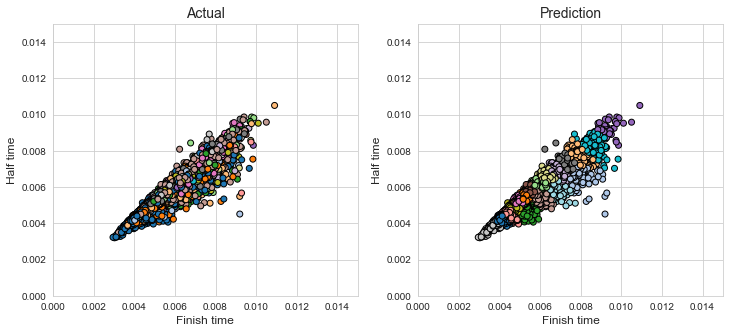

In [50]:
# Instantiating the KMeans model
kmeans_gender = KMeans(n_clusters=18).fit(X_d_train)
Y_d_km_pred = kmeans_gender.predict(X_d_test)

# Evaluation
print('Adjusted Rand Score: ', adjusted_rand_score(Y_d_test, Y_d_km_pred))


# Plotting the true and predicted clusters
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(X_d_test[:, 0], X_d_test[:, 1], c=Y_d_test, cmap='tab20', edgecolors='k')
plt.title('Actual', size=14)
plt.xlabel('Finish time', size=12)
plt.ylabel('Half time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)

plt.subplot(122)
plt.scatter(X_d_test[:, 0], X_d_test[:, 1], c=Y_d_km_pred, cmap='tab20', edgecolors='k')
plt.title('Prediction', size=14)
plt.xlabel('Finish time', size=12)
plt.ylabel('Half time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)
plt.show()

Mean Shift Bandwidth:  0.0015231798665022685
Number of clusters:  2
Adjusted Rand Score:  0.0005826519033304676


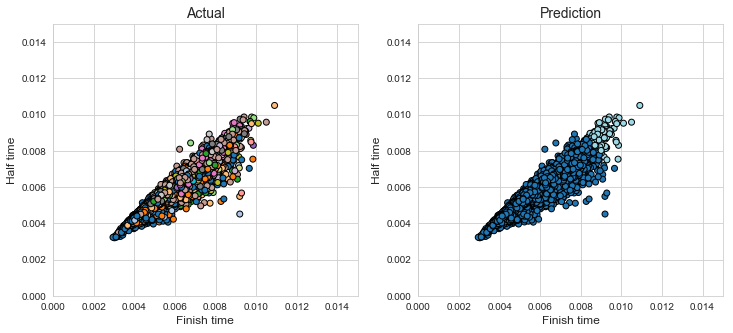

In [53]:
# Estimating the bandwidth hyperparameter
bw = estimate_bandwidth(X_d_train, quantile=0.5, n_jobs=3)

# Instantiating the mean shift model
meanshift_division = MeanShift(bandwidth=bw, n_jobs=3).fit(X_d_train)
Y_d_ms_pred = meanshift_division.predict(X_d_test)

# Evaluation
print('Mean Shift Bandwidth: ', bw)
print('Number of clusters: ', len(np.unique(meanshift_division.labels_)))
print('Adjusted Rand Score: ', adjusted_rand_score(Y_d_test, Y_d_ms_pred))


# Plotting the true and predicted clusters
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(X_d_test[:, 0], X_d_test[:, 1], c=Y_d_test, cmap='tab20', edgecolors='k')
plt.title('Actual', size=14)
plt.xlabel('Finish time', size=12)
plt.ylabel('Half time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)

plt.subplot(122)
plt.scatter(X_d_test[:, 0], X_d_test[:, 1], c=Y_d_ms_pred, cmap='tab20', edgecolors='k')
plt.title('Prediction', size=14)
plt.xlabel('Finish time', size=12)
plt.ylabel('Half time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)
plt.show()

Adjusted Rand Score:  0.010047615140567965


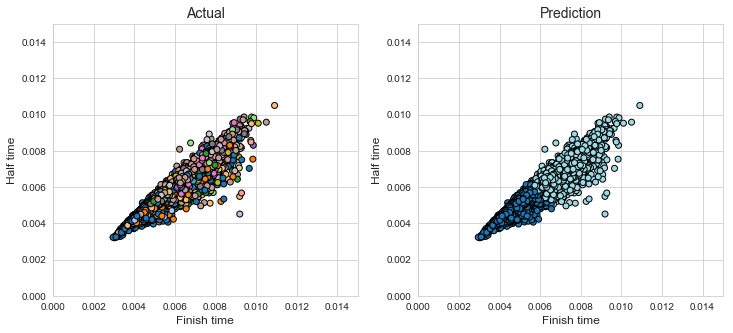

In [55]:
# Spectral Clustering model instantiation
sc_division = SpectralClustering(n_clusters=2, n_jobs=3)
Y_d_sc_pred = sc_division.fit_predict(X_d_test)

# Evaluation
print('Adjusted Rand Score: ', adjusted_rand_score(Y_d_test, Y_d_sc_pred))


# Plotting the true and predicted clusters
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(X_d_test[:, 0], X_d_test[:, 1], c=Y_d_test, cmap='tab20', edgecolors='k')
plt.title('Actual', size=14)
plt.xlabel('Finish time', size=12)
plt.ylabel('Half time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)

plt.subplot(122)
plt.scatter(X_d_test[:, 0], X_d_test[:, 1], c=Y_d_sc_pred, cmap='tab20', edgecolors='k')
plt.title('Prediction', size=14)
plt.xlabel('Finish time', size=12)
plt.ylabel('Half time', size=12)
plt.xlim(0, 0.015)
plt.ylim(0, 0.015)
plt.show()